Data Visualization and Preprocessing

100%|██████████| 169M/169M [00:03<00:00, 43.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


100%|██████████| 182M/182M [00:08<00:00, 22.2MB/s]


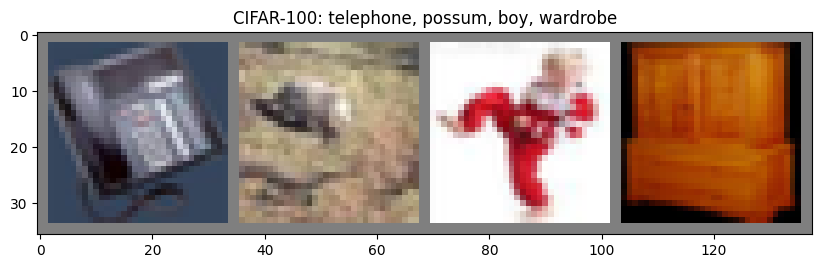

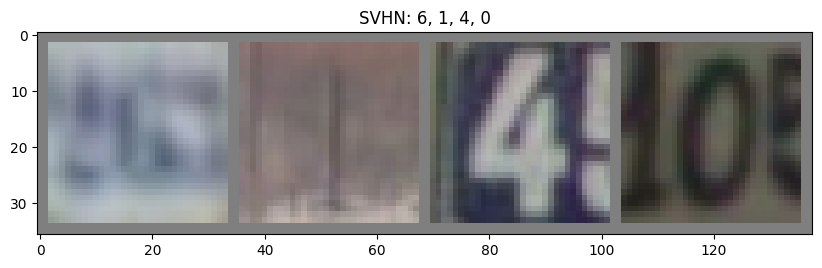

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
cifar100_trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)
cifar100_classes = cifar100_trainset.classes

# Load SVHN dataset
svhn_trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform
)

# Function to display images and labels
def imshow(img, labels, classes, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Display CIFAR-100 samples
data_loader_cifar100 = torch.utils.data.DataLoader(cifar100_trainset, batch_size=4, shuffle=True)
dataiter_cifar100 = iter(data_loader_cifar100)
images_cifar100, labels_cifar100 = next(dataiter_cifar100)

# Get label names for CIFAR-100
cifar100_label_names = [cifar100_classes[label] for label in labels_cifar100]

imshow(torchvision.utils.make_grid(images_cifar100), labels_cifar100, cifar100_classes, \
       f"CIFAR-100: {', '.join(cifar100_label_names)}")

# Display SVHN samples
data_loader_svhn = torch.utils.data.DataLoader(svhn_trainset, batch_size=4, shuffle=True)
dataiter_svhn = iter(data_loader_svhn)
images_svhn, labels_svhn = next(dataiter_svhn)

imshow(torchvision.utils.make_grid(images_svhn), labels_svhn, [str(i) for i in range(10)], \
       f"SVHN: {', '.join(labels_svhn.numpy().astype(str))}")


#CIFAR100

ResNet50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained ResNet50 model and adjust for CIFAR-100
print('==> Loading pretrained ResNet50 model..')
net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)
net = net.to(device)

# Fine-tune the model on CIFAR-100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Starting fine-tuning on CIFAR-100..")
for epoch in range(25):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

# Define FGSM and PGD attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

# Carlini-Wagner attack function
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Test function to evaluate model accuracy on clean or adversarial examples
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

# Evaluate on clean images
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

# Parameters for FGSM, PGD, and C&W attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Testing the pretrained ResNet50 model on FGSM, PGD, and C&W attacks
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained ResNet50 Accuracy on Clean and Adversarial Examples (CIFAR-100)')
plt.show()


Files already downloaded and verified
Files already downloaded and verified
==> Loading pretrained ResNet50 model..


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


==> Starting fine-tuning on CIFAR-100..
Epoch 1: Train Loss: 2.736 | Train Accuracy: 44.12%


KeyboardInterrupt: 

VGG19

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained VGG19 model and adjust for CIFAR-100
print('==> Loading pretrained VGG19 model..')
net = models.vgg19(pretrained=True)
net.classifier[6] = nn.Linear(net.classifier[6].in_features, 100)  # Adjust final layer for CIFAR-100
net = net.to(device)

# Fine-tune the model on CIFAR-100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Starting fine-tuning on CIFAR-100..")
for epoch in range(25):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

# Define FGSM and PGD attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

# Carlini-Wagner attack function
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Test function to evaluate model accuracy on clean or adversarial examples
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

# Evaluate on clean images
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

# Parameters for FGSM, PGD, and C&W attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Testing the pretrained VGG19 model on FGSM, PGD, and C&W attacks
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained VGG19 Accuracy on Clean and Adversarial Examples (CIFAR-100)')
plt.show()


MobileNetV2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained MobileNetV2 model and adjust for CIFAR-100
print('==> Loading pretrained MobileNetV2 model..')
net = models.mobilenet_v2(pretrained=True)
net.classifier[1] = nn.Linear(net.last_channel, 100)
net = net.to(device)

# Fine-tune the model on CIFAR-100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Starting fine-tuning on CIFAR-100..")
for epoch in range(25):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

# Define FGSM and PGD attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

# Carlini-Wagner attack function
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Test function to evaluate model accuracy on clean or adversarial examples
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

# Evaluate on clean images
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

# Parameters for FGSM, PGD, and C&W attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Testing the pretrained MobileNetV2 model on FGSM, PGD, and C&W attacks
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained MobileNetV2 Accuracy on Clean and Adversarial Examples (CIFAR-100)')
plt.show()


#SVHN Dataset

Resnet50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare SVHN dataset
from torchvision.datasets import SVHN

transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),  # SVHN mean and std
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),  # SVHN mean and std
])

trainset = SVHN(root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = SVHN(root='./data', split='test', download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained ResNet50 model and adjust for SVHN
print('==> Loading pretrained ResNet50 model..')
net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)  # Adjust final layer for SVHN (10 classes)
net = net.to(device)

# Fine-tune the model on SVHN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Starting fine-tuning on SVHN..")
for epoch in range(25):  # Adjust number of epochs as needed
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

# Define FGSM and PGD attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

# Carlini-Wagner attack function
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Test function to evaluate model accuracy on clean or adversarial examples
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

# Evaluate on clean images
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

# Parameters for FGSM, PGD, and C&W attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Testing the pretrained ResNet50 model on FGSM, PGD, and C&W attacks
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained ResNet50 Accuracy on Clean and Adversarial Examples (SVHN)')
plt.show()


100%|██████████| 182M/182M [00:17<00:00, 10.5MB/s]


100%|██████████| 64.3M/64.3M [00:12<00:00, 5.22MB/s]


==> Loading pretrained ResNet50 model..


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> Starting fine-tuning on SVHN..
Epoch 1: Train Loss: 0.731 | Train Accuracy: 76.45%
Epoch 2: Train Loss: 0.209 | Train Accuracy: 93.94%
Epoch 3: Train Loss: 0.153 | Train Accuracy: 95.73%
Epoch 4: Train Loss: 0.113 | Train Accuracy: 96.95%
Epoch 5: Train Loss: 0.083 | Train Accuracy: 97.81%
Epoch 6: Train Loss: 0.061 | Train Accuracy: 98.44%
Epoch 7: Train Loss: 0.044 | Train Accuracy: 98.80%
Epoch 8: Train Loss: 0.033 | Train Accuracy: 99.15%
Epoch 9: Train Loss: 0.028 | Train Accuracy: 99.23%
Epoch 10: Train Loss: 0.021 | Train Accuracy: 99.39%
Epoch 11: Train Loss: 0.019 | Train Accuracy: 99.45%
Epoch 12: Train Loss: 0.013 | Train Accuracy: 99.63%
Epoch 13: Train Loss: 0.014 | Train Accuracy: 99.59%
Epoch 14: Train Loss: 0.009 | Train Accuracy: 99.78%
Epoch 15: Train Loss: 0.008 | Train Accuracy: 99.80%
Epoch 16: Train Loss: 0.010 | Train Accuracy: 99.71%
Epoch 17: Train Loss: 0.009 | Train Accuracy: 99.75%
Epoch 18: Train Loss: 0.007 | Train Accuracy: 99.81%


VGG19

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare SVHN dataset
from torchvision.datasets import SVHN

transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),  # SVHN mean and std
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),  # SVHN mean and std
])

trainset = SVHN(root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = SVHN(root='./data', split='test', download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained VGG19 model and adjust for SVHN
print('==> Loading pretrained VGG19 model..')
net = models.vgg19(pretrained=True)
net.classifier[6] = nn.Linear(4096, 10)  # Adjust final layer for SVHN (10 classes)
net = net.to(device)

# Fine-tune the model on SVHN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Starting fine-tuning on SVHN..")
for epoch in range(25):  # Adjust number of epochs as needed
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

# Define FGSM and PGD attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

# Carlini-Wagner attack function
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Test function to evaluate model accuracy on clean or adversarial examples
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

# Evaluate on clean images
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

# Parameters for FGSM, PGD, and C&W attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Testing the pretrained VGG19 model on FGSM, PGD, and C&W attacks
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained VGG19 Accuracy on Clean and Adversarial Examples (SVHN)')
plt.show()


MobilenetV2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare SVHN dataset
from torchvision.datasets import SVHN

transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),  # SVHN mean and std
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),  # SVHN mean and std
])

trainset = SVHN(root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = SVHN(root='./data', split='test', download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained MobileNetV2 model and adjust for SVHN
print('==> Loading pretrained MobileNetV2 model..')
net = models.mobilenet_v2(pretrained=True)
net.classifier[1] = nn.Linear(net.last_channel, 10)  # Adjust final layer for SVHN (10 classes)
net = net.to(device)

# Fine-tune the model on SVHN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Starting fine-tuning on SVHN..")
for epoch in range(25):  # Adjust number of epochs as needed
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

# Define FGSM and PGD attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

# Carlini-Wagner attack function
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Test function to evaluate model accuracy on clean or adversarial examples
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

# Evaluate on clean images
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

# Parameters for FGSM, PGD, and C&W attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Testing the pretrained MobileNetV2 model on FGSM, PGD, and C&W attacks
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained MobileNetV2 Accuracy on Clean and Adversarial Examples (SVHN)')
plt.show()


#Diffensive Distilations

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained ResNet50 model and adjust for CIFAR-100
print('==> Loading pretrained ResNet50 model..')
teacher_model = models.resnet50(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 100)  # Adjust final layer for CIFAR-100
teacher_model = teacher_model.to(device)

# Train the teacher model (pretrained ResNet50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Fine-tuning the teacher model..")
for epoch in range(5):  # Adjust epochs as needed
    teacher_model.train()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Generate soft labels with temperature
def generate_soft_labels(model, dataloader, temperature=10):
    soft_labels = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs) / temperature
            soft_labels.append((inputs, torch.softmax(outputs, dim=1)))
    return soft_labels

soft_train_labels = generate_soft_labels(teacher_model, trainloader)

# Train the distilled (student) model
student_model = models.resnet50(pretrained=True)
student_model.fc = nn.Linear(student_model.fc.in_features, 100)  # Adjust final layer for CIFAR-100
student_model = student_model.to(device)

optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

def train_student(model, soft_labels, temperature=10):
    model.train()
    for epoch in range(5):
        total_loss = 0
        for inputs, soft_targets in soft_labels:
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) / temperature
            loss = nn.KLDivLoss()(torch.log_softmax(outputs, dim=1), soft_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(soft_labels):.3f}")

print("==> Training the student model with defensive distillation..")
train_student(student_model, soft_train_labels)

# Evaluate the student model under adversarial attacks
def test_adversarial_defense(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    model.eval()
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy on {attack if attack else "clean"} examples: {acc:.2f}%')
    return acc

# FGSM, PGD, and CW attack functions remain the same as before
# Parameters for FGSM, PGD, and CW attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Test the student model
print("==> Evaluating the student model under adversarial attacks..")
acc_clean = test_adversarial_defense(student_model)
acc_fgsm = test_adversarial_defense(student_model, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial_defense(student_model, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial_defense(student_model, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Defensive Distillation with ResNet50 (CIFAR-100)')
plt.show()


VGG19

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained VGG19 model and adjust for CIFAR-100
print('==> Loading pretrained VGG19 model as the teacher model..')
teacher_model = models.vgg19(pretrained=True)
teacher_model.classifier[6] = nn.Linear(4096, 100)  # Adjust the final layer for CIFAR-100
teacher_model = teacher_model.to(device)

# Train the teacher model (pretrained VGG19)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Fine-tuning the teacher model..")
for epoch in range(5):  # Adjust epochs as needed
    teacher_model.train()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Generate soft labels with temperature
def generate_soft_labels(model, dataloader, temperature=10):
    soft_labels = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs) / temperature
            soft_labels.append((inputs, torch.softmax(outputs, dim=1)))
    return soft_labels

soft_train_labels = generate_soft_labels(teacher_model, trainloader)

# Train the distilled (student) model
student_model = models.vgg19(pretrained=True)
student_model.classifier[6] = nn.Linear(4096, 100)  # Adjust the final layer for CIFAR-100
student_model = student_model.to(device)

optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

def train_student(model, soft_labels, temperature=10):
    model.train()
    for epoch in range(5):
        total_loss = 0
        for inputs, soft_targets in soft_labels:
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) / temperature
            loss = nn.KLDivLoss()(torch.log_softmax(outputs, dim=1), soft_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(soft_labels):.3f}")

print("==> Training the student model with defensive distillation..")
train_student(student_model, soft_train_labels)

# FGSM, PGD, and CW attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Evaluate the student model under adversarial attacks
def test_adversarial_defense(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    model.eval()
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy on {attack if attack else "clean"} examples: {acc:.2f}%')
    return acc

# Parameters for FGSM, PGD, and CW attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Test the student model
print("==> Evaluating the student model under adversarial attacks..")
acc_clean = test_adversarial_defense(student_model)
acc_fgsm = test_adversarial_defense(student_model, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial_defense(student_model, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial_defense(student_model, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Defensive Distillation with VGG19 (CIFAR-100)')
plt.show()


MobileNetv2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load pretrained MobileNetV2 model and adjust for CIFAR-100
print('==> Loading pretrained MobileNetV2 model as the teacher model..')
teacher_model = models.mobilenet_v2(pretrained=True)
teacher_model.classifier[1] = nn.Linear(teacher_model.last_channel, 100)  # Adjust the final layer for CIFAR-100
teacher_model = teacher_model.to(device)

# Train the teacher model (pretrained MobileNetV2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Fine-tuning the teacher model..")
for epoch in range(5):  # Adjust epochs as needed
    teacher_model.train()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Generate soft labels with temperature
def generate_soft_labels(model, dataloader, temperature=10):
    soft_labels = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs) / temperature
            soft_labels.append((inputs, torch.softmax(outputs, dim=1)))
    return soft_labels

soft_train_labels = generate_soft_labels(teacher_model, trainloader)

# Train the distilled (student) model
student_model = models.mobilenet_v2(pretrained=True)
student_model.classifier[1] = nn.Linear(student_model.last_channel, 100)  # Adjust the final layer for CIFAR-100
student_model = student_model.to(device)

optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

def train_student(model, soft_labels, temperature=10):
    model.train()
    for epoch in range(5):
        total_loss = 0
        for inputs, soft_targets in soft_labels:
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) / temperature
            loss = nn.KLDivLoss()(torch.log_softmax(outputs, dim=1), soft_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(soft_labels):.3f}")

print("==> Training the student model with defensive distillation..")
train_student(student_model, soft_train_labels)

# FGSM, PGD, and CW attack functions
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

# Evaluate the student model under adversarial attacks
def test_adversarial_defense(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    model.eval()
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy on {attack if attack else "clean"} examples: {acc:.2f}%')
    return acc

# Parameters for FGSM, PGD, and CW attacks
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

# Test the student model
print("==> Evaluating the student model under adversarial attacks..")
acc_clean = test_adversarial_defense(student_model)
acc_fgsm = test_adversarial_defense(student_model, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial_defense(student_model, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial_defense(student_model, attack='CW')

# Plot results
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Defensive Distillation with MobileNetV2 (CIFAR-100)')
plt.show()
